In [1]:
import sys
import os

src = "/media/sergiu/lappie/data/work/andersson/src/src"

crispr_location = "/media/sergiu/lappie/data/work/andersson/data/lmo_full/LMO_full_crass.crispr"
spacer_distances_to_flankers_file = "/media/sergiu/lappie/data/work/andersson/data/lmo_full/lmo_full_spacer_distances_to_flankers.txt"
spacer_distances_to_sinks_file = "/media/sergiu/lappie/data/work/andersson/data/lmo_full/lmo_full_spacer_distances_to_sinks.txt"

if not os.path.isdir(src):
    print("Path not valid!")
    
if not src in sys.path:
    sys.path.append(src)
else:
    print(sys.path)

import crass_crispr_parser as crispr

In [2]:
doc = crispr.import_crass_crispr(crispr_location)

Done!


In [3]:
def get_group(doc, gid):
    for group in doc[u'crispr'][u'group']:
        if group['@gid']==gid:
            return group

#gid = "G988942"
#gid = "G1249"  # short spacers, has flanker
gid = "G1505146"
# get the report for a certain @gid
group = get_group(doc, gid)

In [4]:
contigs = group['assembly']['contig']
contigs

[OrderedDict([('@cid', 'C1'),
              ('cspacer',
               [OrderedDict([('@spid', 'SP1059'),
                             ('bspacers',
                              OrderedDict([('bs',
                                            OrderedDict([('@drconf', '0'),
                                                         ('@drid', 'DR1'),
                                                         ('@spid',
                                                          'SP969')]))]))]),
                OrderedDict([('@spid', 'SP586'),
                             ('bspacers',
                              OrderedDict([('bs',
                                            OrderedDict([('@drconf', '0'),
                                                         ('@drid', 'DR1'),
                                                         ('@spid',
                                                          'SP620')]))])),
                             ('fspacers',
                              Order

In [5]:
def extract_cspacer(spacer):
    # each node (spacer) in the path lists forward and backward spacers
    bsp = set()
    if 'bspacers' in spacer:
        if isinstance(spacer['bspacers']['bs'], list):
            for s in spacer['bspacers']['bs']:
                bsp.add(s['@spid'])
        else:
            bsp.add(spacer['bspacers']['bs']['@spid'])
    fsp = set()
    if 'fspacers' in spacer:
        if isinstance(spacer['fspacers']['fs'], list):
            for s in spacer['fspacers']['fs']:
                fsp.add(s['@spid'])
        else:
            fsp.add(spacer['fspacers']['fs']['@spid'])
    if 'fflankers' in spacer:
        if isinstance(spacer['fflankers']['ff'], list):
            for s in spacer['fflankers']['ff']:
                fsp.add('FL'+s['@flid'][2:])
        else:
            fsp.add('FL'+spacer['fflankers']['ff']['@flid'][2:])
    return (bsp, fsp)

contigs = group['assembly']['contig']
graph_dic = {}
for contig in contigs:
    if 'cspacer' in contig:
        cspacers = contig['cspacer']
        if isinstance(cspacers, list):
            for spacer in cspacers:
                spid = spacer['@spid']
                # discard the flankers, their bspacers are wrongly marked as FL
                if not spid[:2]=='FL':
                    graph_dic[spid] = extract_cspacer(spacer)
        else:
            # in this cases xmltodic decided to be stupid and not use lists of one element
            spid = cspacers['@spid']
            # discard the flankers, their bspacers are wrongly marked as FL
            if not spid[:2]=='FL':
                graph_dic[spid] = extract_cspacer(cspacers)
            
print(graph_dic)


{'SP1059': ({'SP969'}, set()), 'SP586': ({'SP620'}, {'SP969'}), 'SP620': (set(), {'SP586'}), 'SP969': ({'SP586'}, {'SP1059'}), 'SP882': (set(), {'SP1121'}), 'SP1121': ({'SP882'}, set()), 'SP97': ({'SP248'}, {'FL42'}), 'SP248': ({'SP393'}, {'SP97'}), 'SP393': ({'SP120'}, {'SP248'}), 'SP473': ({'SP311'}, set()), 'SP311': ({'SP167'}, {'SP473'}), 'SP59': ({'SP348'}, set()), 'SP244': (set(), {'SP811'}), 'SP811': ({'SP244'}, {'SP348'}), 'SP348': ({'SP811'}, {'SP59'}), 'SP363': ({'SP760'}, {'SP85'}), 'SP85': ({'SP363'}, set()), 'SP760': (set(), {'SP363'}), 'SP743': ({'SP1105'}, set()), 'SP1105': (set(), {'SP743'}), 'SP455': ({'SP669'}, {'SP91'}), 'SP91': ({'SP455'}, set()), 'SP669': (set(), {'SP455'}), 'SP273': ({'SP167'}, {'SP102'}), 'SP102': ({'SP273'}, set()), 'SP750': (set(), {'SP834'}), 'SP834': ({'SP750'}, set()), 'SP79': ({'SP160'}, {'FL276'}), 'SP160': (set(), {'SP79'}), 'SP220': (set(), {'FL799'}), 'SP1070': ({'SP876'}, {'SP666'}), 'SP876': (set(), {'SP1070'}), 'SP666': ({'SP1070'}, 

Now making this a networkx graph and printing it..

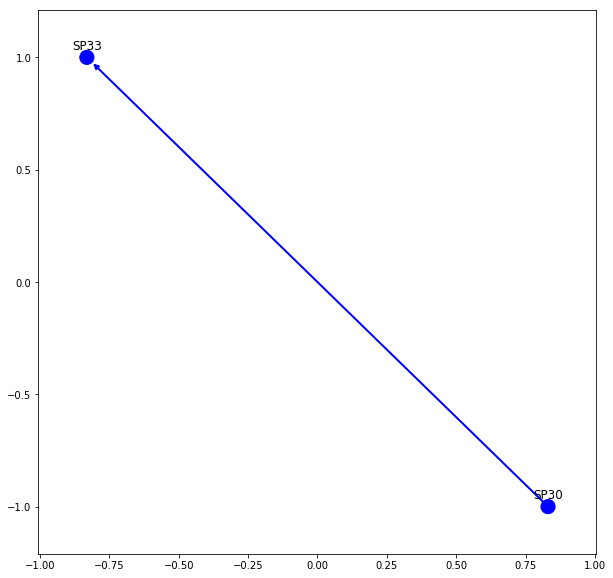

In [9]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()
for node in graph_dic:
    bnodes, fnodes = graph_dic[node]
    for n in bnodes:
        G.add_edge(n, node)
    for n in fnodes:
        G.add_edge(node, n)

plt.figure(figsize=(10, 10), facecolor="w", frameon=False)
pos = nx.spring_layout(G)
#pos = nx.kamada_kawai_layout(G)

offset = .05
pos_labels = {}
keys = pos.keys()
for key in keys:
    x, y = pos[key]
    pos_labels[key] = (x, y + offset)

#node_colors = [G.node[key]['fillcolor'] for key in G.node]
node_colors = ['b' for key in G.node]
nx.draw_networkx_nodes(G, pos, node_size=200, node_shape='o', node_color=node_colors)
nx.draw_networkx_edges(G, pos, width=2, edge_color='b')
nx.draw_networkx_labels(G, pos_labels, fontsize=2)
plt.show()

In [7]:
U = G.to_undirected()
for n in U:
    if n[:2]=="FL":
        print(n)
        # only possible for undirected
        print(nx.node_connected_component(U, n))

for n in G:
    if n[:2]=="FL":
        print(nx.shortest_path(G, target=n))

endnodes = [x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)>0]
print(endnodes)

FL42
{'FL662', 'SP764', 'SP393', 'SP273', 'SP827', 'SP97', 'SP382', 'SP214', 'SP719', 'SP102', 'SP367', 'FL42', 'SP311', 'SP473', 'SP1061', 'SP770', 'SP167', 'SP445', 'SP120', 'SP248'}
FL276
{'SP79', 'SP160', 'FL276'}
FL799
{'FL799', 'SP220'}
FL662
{'FL662', 'SP764', 'SP393', 'SP273', 'SP827', 'SP97', 'SP382', 'SP214', 'SP719', 'SP102', 'SP367', 'SP473', 'SP311', 'SP1061', 'FL42', 'SP770', 'SP167', 'SP445', 'SP120', 'SP248'}
FL389
{'FL108', 'SP68', 'SP73', 'SP27', 'SP48', 'SP55', 'SP10', 'SP170', 'SP16', 'SP254', 'SP369', 'FL389', 'SP151', 'SP457', 'SP112', 'FL156', 'FL414', 'SP1087', 'SP321', 'SP22', 'SP338', 'SP422'}
FL156
{'FL108', 'SP68', 'SP73', 'SP27', 'SP48', 'SP55', 'SP10', 'SP170', 'SP16', 'SP254', 'SP369', 'FL389', 'SP151', 'SP457', 'SP112', 'FL156', 'FL414', 'SP1087', 'SP321', 'SP22', 'SP338', 'SP422'}
FL414
{'FL108', 'SP68', 'SP73', 'SP27', 'SP48', 'SP55', 'SP10', 'SP170', 'SP16', 'SP254', 'SP369', 'SP151', 'FL389', 'SP457', 'SP112', 'FL414', 'FL156', 'SP1087', 'SP321', 'SP

# Wrapping it up


In [8]:
import sys
import os
import json
import networkx as nx

src = "/media/sergiu/lappie/data/work/andersson/src/src"

crispr_location = "/media/sergiu/lappie/data/work/andersson/data/lmo_full/LMO_full_crass.crispr"
spacer_distances_to_flankers_file = "/media/sergiu/lappie/data/work/andersson/data/lmo_full/lmo_full_spacer_distances_to_flankers.txt"
spacer_distances_to_sinks_file = "/media/sergiu/lappie/data/work/andersson/data/lmo_full/lmo_full_spacer_distances_to_sinks.txt"

#crispr_location = "/media/sergiu/workpc/data/work/andersson/data/lmo2013_2014/crass.crispr"
#spacer_distances_to_flankers_file = "/media/sergiu/workpc/data/work/andersson/data/lmo2013_2014/lmo2012_2014_spacer_distances_to_flankers.txt"
#spacer_distances_to_sinks_file = "/media/sergiu/workpc/data/work/andersson/data/lmo2013_2014/lmo2012_2014_spacer_distances_to_sinks.txt"

if not os.path.isdir(src):
    print("Path not valid!")
    
if not src in sys.path:
    sys.path.append(src)
else:
    print(sys.path)

import crass_crispr_parser as crispr

def extract_cspacer(spacer):
    # each node (spacer) in the path lists forward and backward spacers
    bsp = set()
    if 'bspacers' in spacer:
        if isinstance(spacer['bspacers']['bs'], list):
            for s in spacer['bspacers']['bs']:
                bsp.add(s['@spid'])
        else:
            bsp.add(spacer['bspacers']['bs']['@spid'])
    fsp = set()
    if 'fspacers' in spacer:
        if isinstance(spacer['fspacers']['fs'], list):
            for s in spacer['fspacers']['fs']:
                fsp.add(s['@spid'])
        else:
            fsp.add(spacer['fspacers']['fs']['@spid'])
    if 'fflankers' in spacer:
        if isinstance(spacer['fflankers']['ff'], list):
            for s in spacer['fflankers']['ff']:
                fsp.add('FL'+s['@flid'][2:])
        else:
            fsp.add('FL'+spacer['fflankers']['ff']['@flid'][2:])
    return (bsp, fsp)


def get_spacer_distances_to_flankers(graph_dic):
    flanker_dict = {}
    G=nx.DiGraph()
    for node in graph_dic:
        bnodes, fnodes = graph_dic[node]
        for n in bnodes:
            G.add_edge(n, node)
        for n in fnodes:
            G.add_edge(node, n)
    for n in G:
        if n[:2]=="FL":
            flanker_dict[n] = nx.shortest_path(G, target=n)
    return flanker_dict

def get_spacer_distances_to_sinks(graph_dic):
    contig_dict = {}
    G=nx.DiGraph()
    for node in graph_dic:
        bnodes, fnodes = graph_dic[node]
        for n in bnodes:
            G.add_edge(n, node)
        for n in fnodes:
            G.add_edge(node, n)
    endnodes = [x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)>0]
    for n in endnodes:
        contig_dict[n] = nx.shortest_path(G, target=n)
    return contig_dict


doc = crispr.import_crass_crispr(crispr_location)
spacer_distances_flankers = {}
spacer_distances_sinks = {}

for igroup, group in enumerate(doc[u'crispr'][u'group'][:]):
    gid = group[u'@gid']
    contigs = group['assembly']['contig']
    graph_dic = {}
    for contig in contigs:
        if 'cspacer' in contig:
            cspacers = contig['cspacer']
            if isinstance(cspacers, list):
                for spacer in cspacers:
                    spid = spacer['@spid']
                    # discard the flankers, their bspacers are wrongly marked as FL
                    if not spid[:2]=='FL':
                        graph_dic[spid] = extract_cspacer(spacer)
            else:
                # in this cases xmltodic decided to be stupid and not use lists of one element
                spid = cspacers['@spid']
                # discard the flankers, their bspacers are wrongly marked as FL
                if not spid[:2]=='FL':
                    graph_dic[spid] = extract_cspacer(cspacers)
    spacer_distances_flankers[gid] = get_spacer_distances_to_flankers(graph_dic)
    spacer_distances_sinks[gid] = get_spacer_distances_to_sinks(graph_dic)
    

f = open(spacer_distances_to_flankers_file, 'wt')
for gid in spacer_distances_flankers:
    for flid in spacer_distances_flankers[gid]:
        for spid in spacer_distances_flankers[gid][flid]:
            f.write("\t".join([gid, flid, spid, str(len(spacer_distances_flankers[gid][flid][spid])-1)])+'\n')
f.close()

f = open(spacer_distances_to_sinks_file, 'wt')
for gid in spacer_distances_sinks:
    for flid in spacer_distances_sinks[gid]:
        for spid in spacer_distances_sinks[gid][flid]:
            f.write("\t".join([gid, flid, spid, str(len(spacer_distances_sinks[gid][flid][spid])-1)])+'\n')
f.close()

['', '/media/sergiu/lappie/programs/miniconda3/envs/andersson/lib/python36.zip', '/media/sergiu/lappie/programs/miniconda3/envs/andersson/lib/python3.6', '/media/sergiu/lappie/programs/miniconda3/envs/andersson/lib/python3.6/lib-dynload', '/media/sergiu/lappie/programs/miniconda3/envs/andersson/lib/python3.6/site-packages', '/media/sergiu/lappie/programs/miniconda3/envs/andersson/lib/python3.6/site-packages/IPython/extensions', '/home/sergiu/.ipython', '/media/sergiu/lappie/data/work/andersson/src/src']
Done!
